## Working Directory

In [58]:
import os
os.chdir("C:/Users/Bhupender/Desktop/Assignments/Sem 3/ML 2")

## Libraries

In [59]:

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data Preprocessing & Feature Engineering
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

# Sampling and Imbalance
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [60]:
# Load the dataset
data = pd.read_csv('c1.csv')
data = data.drop(columns=['id'])

# Convert target to binary (0 and 1)
y = (data['stroke'] == 1).astype(int)

In [61]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5359 entries, 0 to 5358
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                5359 non-null   float64
 1   avg_glucose_level  5359 non-null   float64
 2   bmi                5118 non-null   float64
 3   ever_married       5359 non-null   object 
 4   feat01             5359 non-null   float64
 5   feat02             5359 non-null   float64
 6   feat03             5359 non-null   float64
 7   feat04             5359 non-null   float64
 8   feat05             5359 non-null   float64
 9   feat06             5359 non-null   float64
 10  feat07             5359 non-null   float64
 11  feat08             5359 non-null   float64
 12  feat09             5359 non-null   float64
 13  feat10             5359 non-null   float64
 14  gender             5359 non-null   object 
 15  heart_disease      5359 non-null   int64  
 16  hypertension       5359 

C:\Users\Bhupender\AppData\Local\Temp\ipykernel_30920\964672960.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=data, palette='coolwarm')


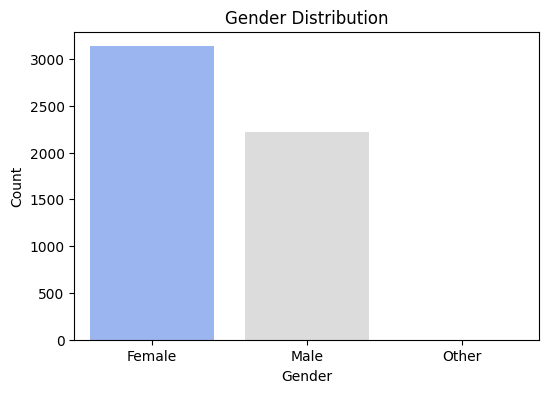

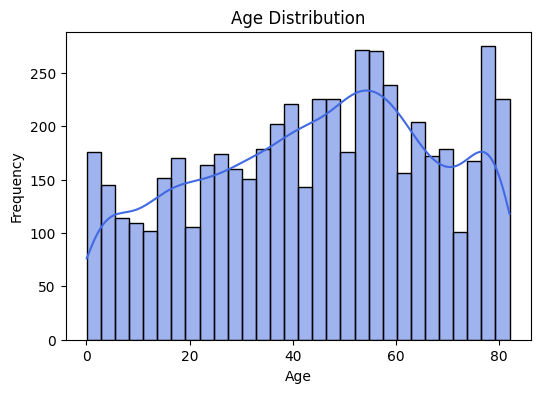

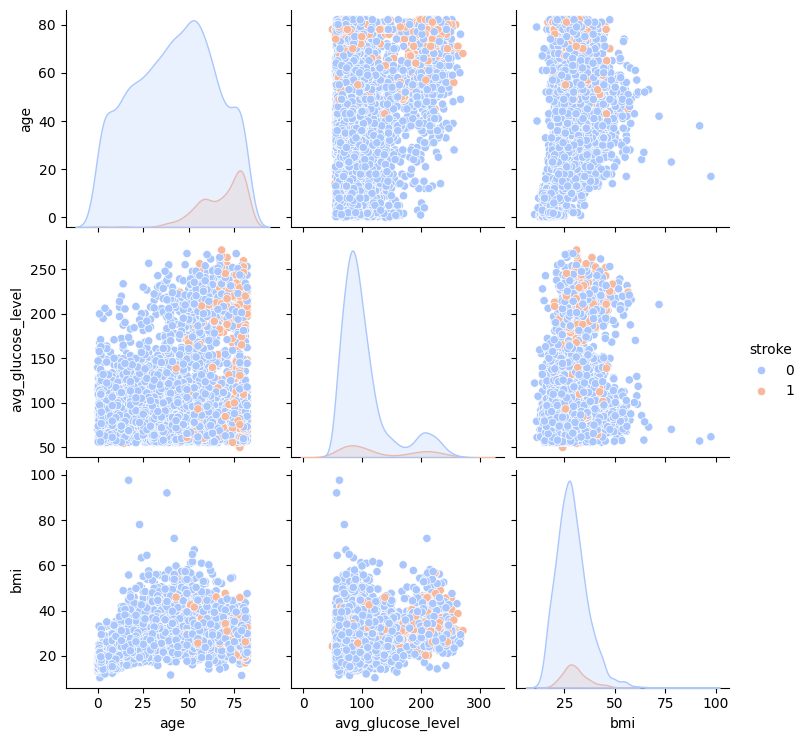

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected Bar Plot - Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=data, palette='coolwarm')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Histogram - Age Distribution
plt.figure(figsize=(6,4))
sns.histplot(data['age'], bins=30, kde=True, color='royalblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Pairplot - Relationship Between Features
selected_features = ['age', 'avg_glucose_level', 'bmi', 'stroke']
sns.pairplot(data[selected_features], hue='stroke', palette='coolwarm', diag_kind='kde')
plt.show()


In [63]:
def create_features(data):
    data['age_glucose'] = data['age'] * data['avg_glucose_level']
    data['age_bmi'] = data['age'] * data['bmi']
    data['glucose_bmi'] = data['avg_glucose_level'] * data['bmi']
    data['age_squared'] = data['age'] ** 2
    data['glucose_squared'] = data['avg_glucose_level'] ** 2
    data['bmi_squared'] = data['bmi'] ** 2
    data['log_age'] = np.log1p(data['age'])
    data['log_glucose'] = np.log1p(data['avg_glucose_level'])
    data['log_bmi'] = np.log1p(data['bmi'])
    data['age_glucose_bmi'] = data['age'] * data['avg_glucose_level'] * data['bmi']
    data['age_glucose_ratio'] = data['age'] / (data['avg_glucose_level'] + 1)
    data['bmi_age_ratio'] = data['bmi'] / (data['age'] + 1)
    data['high_glucose'] = (data['avg_glucose_level'] > 140).astype(int)
    data['very_high_glucose'] = (data['avg_glucose_level'] > 180).astype(int)
    data['obesity'] = (data['bmi'] >= 30).astype(int)
    data['severe_obesity'] = (data['bmi'] >= 35).astype(int)
    data['elderly'] = (data['age'] >= 65).astype(int)
    data['diabetes_risk'] = data['high_glucose'] + data['obesity'] + data['elderly']
    data['severe_risk'] = data['very_high_glucose'] + data['severe_obesity'] + data['elderly']
    data['age_percentile'] = data['age'].rank(pct=True)
    data['glucose_percentile'] = data['avg_glucose_level'].rank(pct=True)
    data['bmi_percentile'] = data['bmi'].rank(pct=True)
    return data

In [64]:
data = create_features(data)

In [65]:

# Handle missing values using multiple imputation
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
imputer1 = KNNImputer(n_neighbors=5)
imputer2 = SimpleImputer(strategy='median')

data_imp1 = data.copy()
data_imp2 = data.copy()

data_imp1[numerical_cols] = imputer1.fit_transform(data[numerical_cols])
data_imp2[numerical_cols] = imputer2.fit_transform(data[numerical_cols])

In [66]:
# Average the imputed values
data[numerical_cols] = (data_imp1[numerical_cols] + data_imp2[numerical_cols]) / 2

# Encode categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [67]:


# Apply robust scaling and quantile transformation to numerical columns
scaler = RobustScaler()
qt = QuantileTransformer(output_distribution='normal')
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data[numerical_cols] = qt.fit_transform(data[numerical_cols])

# Separate features and target
X = data.drop('stroke', axis=1)

# Feature selection using mutual information
n_features = 30  # Increased number of features
selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

In [68]:
# Separate features and target
X = data.drop('stroke', axis=1)

# Feature selection using mutual information
n_features = 30  # Increased number of features
selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

In [75]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import pandas as pd

def create_balanced_samples(X, y):
    """
    Apply multiple resampling techniques (SMOTE, BorderlineSMOTE, ADASYN) 
    and combine them into one dataset for enhanced class balancing.
    """
    # SMOTE variations
    smote1 = SMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=42)
    smote2 = BorderlineSMOTE(sampling_strategy=1.0, k_neighbors=5, random_state=43)
    smote3 = ADASYN(sampling_strategy=1.0, random_state=44)
    
    # Apply different oversampling methods
    X_res1, y_res1 = smote1.fit_resample(X, y)
    X_res2, y_res2 = smote2.fit_resample(X, y)
    X_res3, y_res3 = smote3.fit_resample(X, y)
    
    # Convert to DataFrame
    X_res1, X_res2, X_res3 = map(lambda arr: pd.DataFrame(arr, columns=X.columns), [X_res1, X_res2, X_res3])
    y_res1, y_res2, y_res3 = map(pd.Series, [y_res1, y_res2, y_res3])
    
    # Concatenate resampled datasets
    X_combined = pd.concat([X_res1, X_res2, X_res3], ignore_index=True)
    y_combined = pd.concat([y_res1, y_res2, y_res3], ignore_index=True)
    
    return X_combined, y_combined

# Example usage
X_balanced, y_balanced = create_balanced_samples(X, y)

# Check class distribution
print("Class distribution after resampling:\n", y_balanced.value_counts())

Class distribution after resampling:
 stroke
1    14678
0    14583
Name: count, dtype: int64


In [76]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create balanced samples for training
X_train_balanced, y_train_balanced = create_balanced_samples(X_train, y_train)


In [81]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import pandas as pd

# Function to train models and evaluate performance
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = []
    models = []
    
    # Define models with parameters
    base_models = [
        (XGBClassifier(**xgb_params1), "XGBClassifier1"),
        (XGBClassifier(**xgb_params2), "XGBClassifier2"),
        (RandomForestClassifier(**rf_params1), "RandomForestClassifier1"),
        (RandomForestClassifier(**rf_params2), "RandomForestClassifier2"),
        (LogisticRegression(**logreg_params1), "LogisticRegression1"),
        (LogisticRegression(**logreg_params2), "LogisticRegression2")
    ]
    
    for model, name in base_models:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions and probabilities
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]

        # Calculate Balanced Accuracy and AUC
        train_ba = balanced_accuracy_score(y_train, y_train_pred)
        test_ba = balanced_accuracy_score(y_test, y_test_pred)
        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)

        print(f"{name} - Training BA: {train_ba:.4f}, Training AUC: {train_auc:.4f}")
        print(f"{name} - Testing BA: {test_ba:.4f}, Testing AUC: {test_auc:.4f}\n")

        results.append({
            'Model': name,
            'Training BA': train_ba,
            'Training AUC': train_auc,
            'Testing BA': test_ba,
            'Testing AUC': test_auc
        })
        models.append((model, name))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    return models, results_df

# Train models and collect results
models, results_data = train_and_evaluate_models(X_train_balanced, y_train_balanced, X_test, y_test)


Training XGBClassifier1...
XGBClassifier1 - Training BA: 0.8427, Training AUC: 0.9479
XGBClassifier1 - Testing BA: 0.8011, Testing AUC: 0.8824


Training XGBClassifier2...
XGBClassifier2 - Training BA: 0.8074, Training AUC: 0.9309
XGBClassifier2 - Testing BA: 0.7778, Testing AUC: 0.8822


Training RandomForestClassifier1...
RandomForestClassifier1 - Training BA: 0.8924, Training AUC: 0.9563
RandomForestClassifier1 - Testing BA: 0.7713, Testing AUC: 0.8866


Training RandomForestClassifier2...
RandomForestClassifier2 - Training BA: 0.9148, Training AUC: 0.9718
RandomForestClassifier2 - Testing BA: 0.7666, Testing AUC: 0.8891


Training LogisticRegression1...
LogisticRegression1 - Training BA: 0.8161, Training AUC: 0.8973
LogisticRegression1 - Testing BA: 0.8121, Testing AUC: 0.8778


Training LogisticRegression2...
LogisticRegression2 - Training BA: 0.8164, Training AUC: 0.8969
LogisticRegression2 - Testing BA: 0.8126, Testing AUC: 0.8776



In [80]:
print("Comparison of Models (Balanced Accuracy and AUC):")
print(results_data)

Comparison of Models (Balanced Accuracy and AUC):
                     Model  Training BA  Training AUC  Testing BA  Testing AUC
0           XGBClassifier1     0.842714      0.947941    0.801132     0.882402
1           XGBClassifier2     0.807441      0.930914    0.777840     0.882191
2  RandomForestClassifier1     0.892436      0.956317    0.771317     0.886615
3  RandomForestClassifier2     0.914807      0.971763    0.766605     0.889064
4      LogisticRegression1     0.816110      0.897344    0.812119     0.877819
5      LogisticRegression2     0.816370      0.896925    0.812634     0.877644
